## HW7 S23 - Starter Code

## Q1: NFL Regression

In [28]:
using DataFrames, DelimitedFiles
using PyPlot, JuMP, HiGHS, Ipopt

In [30]:
teams = [ "49ers", "falcons", "ravens", "steelers", "bears", "vikings", "lions", "saints", "bucs", "patriots", "jets", "packers", "chargers", "raiders", "cardinals", "giants", "panthers", "redskins", "jaguars", "browns", "colts", "chiefs", "eagles", "cowboys", "seahawks", "dolphins","titans", "bills", "broncos", "rams", "bengals" ]
teamIDs = Dict( zip( teams, Array(1:31) ) )
data = readdlm( joinpath(@__DIR__, "nfl.inc" ), header=false)
results_table=Array{Int16,2}(undef, size(data,1),4)
for i in 1:size( data, 1 )
    base = data[ i, 1 ]
    res = data[ i, 2 ]
    splits = split( base, "." )
    week = parse( Int64, splits[1] )
    away = splits[2]
    home = splits[3]
    hid = teamIDs[home]
    aid = teamIDs[away]
    results_table[i,1]=week
    results_table[i,2]=aid
    results_table[i,3]=hid
    results_table[i,4]=res
end
print(results_table)


n_terms=size(results_table,1)
n_teams=31

Int16[1 1 2 8; 1 3 4 -16; 1 5 6 3; 1 7 8 -4; 1 9 10 -5; 1 11 12 -4; 1 13 14 3; 1 15 16 5; 1 17 18 3; 1 19 20 -20; 1 21 22 -13; 1 23 24 -27; 1 26 25 23; 1 27 28 3; 1 29 30 5; 2 2 29 28; 2 5 9 41; 2 12 28 9; 2 22 27 3; 2 8 13 -1; 2 14 21 -7; 2 18 7 5; 2 17 1 -16; 2 20 31 -17; 2 19 3 3; 2 26 6 6; 2 16 23 -15; 2 30 25 -3; 2 24 15 1; 2 10 11 1; 3 4 20 3; 3 9 7 -21; 3 23 12 3; 3 1 30 17; 3 28 11 13; 3 2 17 -5; 3 31 19 13; 3 13 22 32; 3 29 14 -9; 3 16 5 -7; 3 6 10 -8; 3 8 25 10; 3 3 26 13; 3 24 18 -6; 4 30 2 -21; 4 1 24 -17; 4 23 8 -14; 4 31 3 37; 4 22 29 -1; 4 25 13 -8; 4 18 16 -10; 4 7 5 -7; 4 10 26 7; 4 27 4 -3; 4 12 15 -26; 4 20 14 26; 4 11 9 -4; 4 19 21 29; 5 21 28 -2; 5 6 7 7; 5 13 30 26; 5 4 19 -11; 5 10 29 -17; 5 15 1 7; 5 2 23 28; 5 3 20 -12; 5 16 27 14; 5 24 17 -3; 5 26 31 -15; 5 5 12 -3; 5 9 18 3; 5 25 22 7; 6 8 5 -21; 6 12 7 7; 6 21 10 8; 6 18 23 -3; 6 20 15 8; 6 29 13 -14; 6 3 19 -5; 6 27 31 -9; 6 28 26 9; 6 4 11 -17; 6 16 2 -7; 6 25 17 23; 6 14 1 -6; 6 9 6 7; 7 13 28 3; 7 17 8 1

31

## Q1a

In [32]:
# Solution for (a)
m = Model(Ipopt.Optimizer)

@variable(m, ratings[1:n_teams])  # Team ratings
@variable(m, home_field)            # Home field advantage
@objective(m, Min, sum((ratings[results_table[i, 3]] - ratings[results_table[i, 2]] + home_field - results_table[i, 4])^2 for i in 1:n_terms))
@constraint(m, sum(ratings) == 0) # constraint to the ratings: They must sum to zero.

optimize!(m)

# print results
for i=1:n_teams
    println(teams[i]," : ",value(ratings[i]))
end
    println("Home field advantage: ", value(home_field))
            

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:       31
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      183

Total number of variables............................:       32
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9333000e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

## Q1b

In [33]:
# Solution for (b)
m = Model(Ipopt.Optimizer)

@variable(m, ratings[1:n_teams])  # Team ratings
@variable(m, home_field)          # Home field advantage
@variable(m, t[1:n_terms])       # Slack variables for L1 regularization
for i in 1:n_terms
    @constraint(m, (ratings[results_table[i,3]] - ratings[results_table[i,2]] + home_field) - results_table[i,4] <= t[i])
    @constraint(m, (ratings[results_table[i,3]] - ratings[results_table[i,2]] + home_field) - results_table[i,4] >= -t[i])
end
@constraint(m, sum(ratings) == 0) # constraint to the ratings: They must sum to zero.
@objective(m, Min, sum(t[i] for i in 1:n_terms)) # L1 regularization

optimize!(m)
# print results
for i=1:n_teams
    println(teams[i]," : ",value(ratings[i]))
end
    println("Home field advantage: ", value(home_field))


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:       31
Number of nonzeros in inequality constraint Jacobian.:     1144
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      175
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:      286
        inequality constraints with only lower bounds:      143
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      143

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.10e+01 3.33e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

There is a slight difference between two ratings. By comparing the two sets of ratings, we can see that the l1 regularization objective function tends to set the ratings towards zeros.

Also, the home field advantage of the l1 regularization is slightly lower.

## Q1C

In [36]:
# Solution for (c)
m = Model(Ipopt.Optimizer)

@variable(m, ratings[1:n_teams])  # Team ratings
@variable(m, home_fields[1:n_teams])  # Home field advantage for each team
@objective(m, Min, sum((ratings[results_table[i, 3]] + home_fields[results_table[i, 3]] - ratings[results_table[i, 2]] - results_table[i, 4])^2 for i in 1:n_terms))
@constraint(m, sum(ratings) == 0)

optimize!(m)

# print results
for i=1:n_teams
    println(teams[i]," : ",value(ratings[i]), ", Home field advantage: ", value(home_fields[i]))
end

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:       31
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      356

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9333000e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

## Q1D

If the Dolphins were to visit the Seahawks, the expected winner according to the sum-of-squares model would be Dolphins with margin -3.7903501768750854. Using the l_1 model, the expected winner would be Dolphins with margin -4.8552428517977235

In [38]:
# Part a: sum-of-squares
ratings_seahawks_a = -1.3183228941788292
ratings_dolphins_a = 4.386500309230531
H_a = 1.9144730265342742

ratings_seahawks_b = -0.12677920124057024
ratings_dolphins_b = 5.8713207925791195
H_b = 1.142857142021966
expected_margin_a = ratings_seahawks_a - ratings_dolphins_a + H_a
println("Expected margin for Dolphins vs. Seahawks (using sum-of-squares): ", expected_margin_a)

expected_margin_b = ratings_seahawks_b - ratings_dolphins_b + H_b
println("Expected margin for Dolphins vs. Seahawks (using l_1 regularization): ", expected_margin_b)

Expected margin for Dolphins vs. Seahawks (using sum-of-squares): -3.7903501768750854
Expected margin for Dolphins vs. Seahawks (using l_1 regularization): -4.8552428517977235


## Q2: Huber Loss

In [40]:
# Q2 Starter Code

using PyPlot, JuMP, Ipopt, Gurobi

x = 1:15
y = [6.31; 3.78; 24; 1.71; 2.99; 4.53; 2.11; 3.88; 4.67; 4.25; 2.06; 23; 1.58; 2.17; 0.02]
# y = 6.31 3.78 24 1.71 2.99 4.53 2.11 3.88 4.67 4.25 2.06 23 1.58 2.17 0.02

15-element Vector{Float64}:
  6.31
  3.78
 24.0
  1.71
  2.99
  4.53
  2.11
  3.88
  4.67
  4.25
  2.06
 23.0
  1.58
  2.17
  0.02

## Q2a : Using an l_2 cost (least squares).

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2623168e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

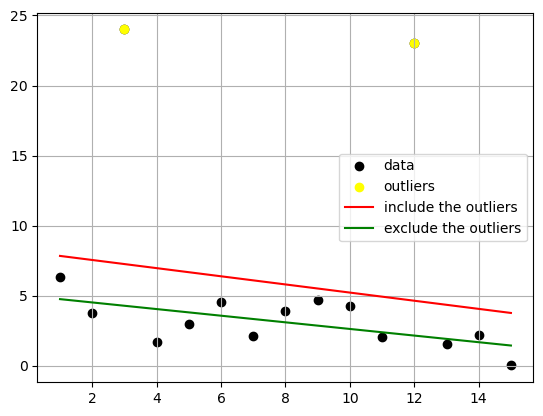

In [42]:
x_excluded = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
y_excluded = [6.31, 3.78, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 1.58, 2.17, 0.02]
# include the outliers
m2a = Model(Ipopt.Optimizer)

@variable(m2a, a1)
@variable(m2a, b1)

@objective(m2a, Min, sum((y[i]-a1*x[i]-b1)^2 for i=1:15) )
optimize!(m2a)

a1 = value(a1)
b1 = value(b1)

println("Best l_2 linear fit including the outliers:")
println("a1: ", a1)
println("b1: ", b1)

# exclude the outliers
m2a2 = Model(Ipopt.Optimizer)

@variable(m2a2, a2)
@variable(m2a2, b2)

@objective(m2a2, Min, sum((y_excluded[i]-a2*x_excluded[i]-b2)^2 for i=1:13))
optimize!(m2a2)

a2 = value(a2)
b2 = value(b2)

println("Best l_2 linear fit excluding the outliers:")
println("a2: ", a2)
println("b2: ", b2)

scatter(x, y, label="data", color="black")
scatter([x[3], x[12]], [y[3], y[12]], label="outliers", color="yellow") # outliers
plot(x, a1*x.+b1, color="red", label="include the outliers")
plot(x, a2*x.+b2, color="green", label="exclude the outliers")
legend()
grid("on")

## Q2b: use the l1 cost function

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       90
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       30
        inequality constraints with only lower bounds:       15
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.40e+01 3.33e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

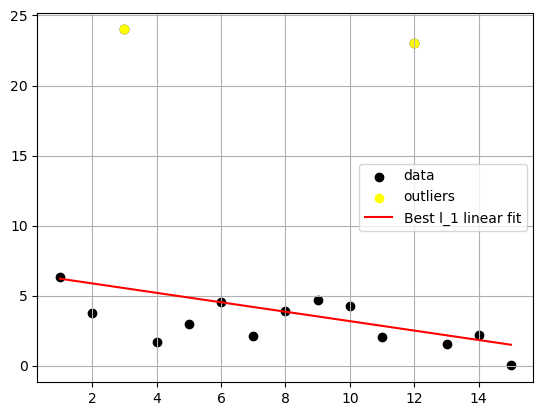

In [43]:
m2b = Model(Ipopt.Optimizer)

@variable(m2b, a)
@variable(m2b, b)
@variable(m2b, t[1:15])

for i in 1:15
    @constraint(m2b, y[i]-a*x[i]-b <= t[i])
    @constraint(m2b, y[i]-a*x[i]-b >= -t[i])
end

@objective(m2b, Min, sum(t))

optimize!(m2b)

a = value(a)
b = value(b)

println("Best l_1 linear fit including the outliers:")
println("a: ", a)
println("b: ", b)

scatter(x, y, label="data", color="black")
scatter([x[3], x[12]], [y[3], y[12]], label="outliers", color="yellow") # outliers
plot(x, a*x.+b, color="red", label="Best l_1 linear fit")
legend()
grid("on")

Therefore, l_1 cost handle outliers better than least squares.
The L1 cost function works in the difference between the actual and predicted values linearly, while the L2 cost function works in the difference square. Then, it would lead to the large deviations.

## Q2c: Use the Huber loss function

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      180
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:       47
                     variables with only lower bounds:       15
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       15
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:       15
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       45

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9999970e-01 2.40e+01 6.47e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

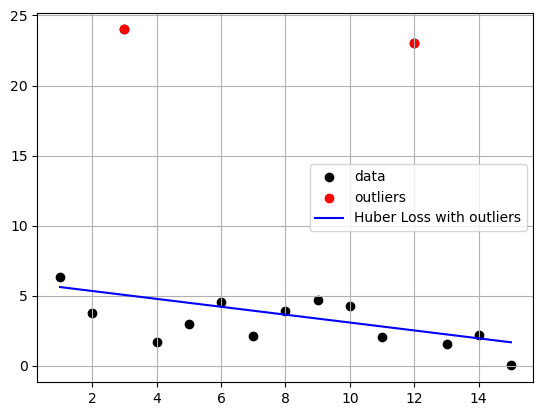

In [49]:
M = 1 # a parameter that determines where the quadratic function transitions to a linear function.

m2c = Model(Ipopt.Optimizer)
@variable(m2c, w[1:15]<=M)
@variable(m2c, v[1:15]>=0)
@variable(m2c, a3)
@variable(m2c, b3)
@variable(m2c, t[1:15])

for i in 1:15
    @constraint(m2c, y[i]-a3*x[i]-b3 <= t[i]+v[i])
    @constraint(m2c, y[i]-a3*x[i]-b3 >= -t[i]-v[i])
    @constraint(m2c, t[i] <= w[i])
    @constraint(m2c, t[i] <= v[i])
    @objective(m2c, Min, sum(w[i]^2 for i=1:15) + 2M*sum(v[i] for i=1:15))
end
optimize!(m2c)
a3 = value(a3)
b3 = value(b3)
scatter(x, y, label="data", color="black")
scatter([x[3], x[12]], [y[3], y[12]], label="outliers", color="red") # outliers
plot(x, a3.*x.+ b3, color="blue", label="Huber Loss with outliers")
legend()
grid("on")

println("Best Huber Loss linear fit:")
println("a: ", a3)
println("b: ", b3)

## Q2d: Draw all 3 fitted lines

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2623168e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

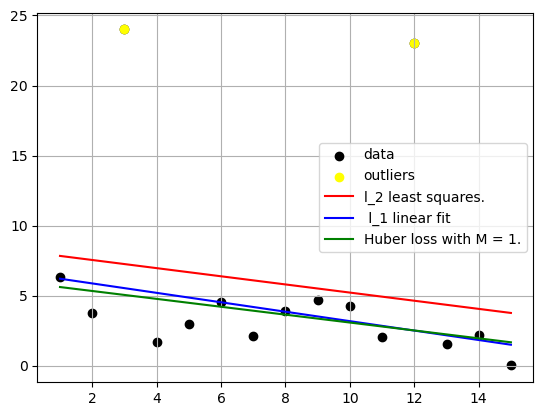

In [44]:
m2a = Model(Ipopt.Optimizer)
@variable(m2a, a1)
@variable(m2a, b1)
@objective(m2a, Min, sum((y[i]-a1*x[i]-b1)^2 for i=1:15) )
optimize!(m2a)
a1 = value(a1)
b1 = value(b1)
  
m2b = Model(Ipopt.Optimizer)
@variable(m2b, a2)
@variable(m2b, b2)
@variable(m2b, t[1:15])
for i in 1:15
    @constraint(m2b, y[i]-a2*x[i]-b2 <= t[i])
    @constraint(m2b, y[i]-a2*x[i]-b2 >= -t[i])
end
@objective(m2b, Min, sum(t))
optimize!(m2b)
a2 = value(a2)
b2 = value(b2)

M = 1 # a parameter that determines where the quadratic function transitions to a linear function.

m2c = Model(Ipopt.Optimizer)
@variable(m2c, w[1:15]<=M)
@variable(m2c, v[1:15]>=0)
@variable(m2c, a3)
@variable(m2c, b3)
@variable(m2c, t[1:15])

for i in 1:15
    @constraint(m2c, y[i]-a3*x[i]-b3 <= t[i]+v[i])
    @constraint(m2c, y[i]-a3*x[i]-b3 >= -t[i]-v[i])
    @constraint(m2c, t[i] <= w[i])
    @constraint(m2c, t[i] <= v[i])
    @objective(m2c, Min, sum(w[i]^2 for i=1:15) + 2M*sum(v[i] for i=1:15))
end
optimize!(m2c)
a3 = value(a3)
b3 = value(b3)
       
scatter(x, y, label="data", color="black")
scatter([x[3], x[12]], [y[3], y[12]], label="outliers", color="yellow") # outliers
plot(x, a1*x.+b1, color="red", label="l_2 least squares.")
plot(x, a2*x.+b2, color="blue", label=" l_1 linear fit")
plot(x, a3.*x.+ b3, color="green", label="Huber loss with M = 1.")
    
legend()
grid("on")


It would be hard to choose which techniques gave the best fit to the non-outlier data because the problem depends on the specific characteristics of the data and the goals of the analysis.

## 3. Heat pipe design

# Q3a
We can express this problem as a geometric program as follows:
-Variables: T, r, w

 max(α_4 *π* T * r^4)

subjects to  T_min <= T <= T_max,r_min <= r <= r_max, w_min <= w <= w_max, 

w <= 0.1*r . α,

α_1*T*r/w + α_2*r + α_3*r*w <= C_max

Then we convert as follows:

min α_4^(-1) * π * T^(-1) * r^(-2))

s.t. T_min/T <= 1, T/T_max <= 1

r_min/r <= 1, r/r_max <= 1

w_min/w <= 1, w/w_max <= 1

10w/r <= 1

α_1*T*r/(C_max*w) + α_2*r/C_max + α_3*r*w/C_max <= 1

Let's define: x := logT, y := logr, and z := logw. The convex optimization problem will be:

min log(e^log(α_4^(-1)-x-2y))

s.t. log(e^(log(T_min)-x)) <= 0, log(e^(log(1/T_max)+x)) <= 0

log(e^(log(r_min)-y)) <= 0, log(e^(log(1/r_max)+y)) <= 0

log(e^(log(w_min)-z)) <= 0, log(e^(log(1/w_max)+z)) <= 0

log(e^(log(10) + z - y)) <= 0

log^(e^(log(α_1/C_max)+x+y-z)+ e^(log(α_2/C_max)+y) + e^(log(α_3/C_max)+y+z) )<= 0

### Q3b

In [50]:
using JuMP, Ipopt

m = Model(Ipopt.Optimizer)
@variable(m, x)
@variable(m, y)
@variable(m, z)

@NLconstraint(m, log(exp(log(1/500)+x+y-z)+ exp(log(1/500)+y)+exp(log(1/500)+y+z))<=0)
@NLconstraint(m, log(exp(log(10)+z-y)) <= 0)
@NLobjective(m, Min, log(exp(log(1)-x-2y)))
optimize!(m)
println("T = ", exp(value(x)))
println("r = ", exp(value(y)))
println("w = ", exp(value(z)))
println("The maximum heat: ",10 * exp(value(x))* exp(value(y))* exp(value(z)))


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.30e+00 7.71e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  